# Bike Sharing Demand

Forecast use of a city bikeshare system

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

![Bikes](https://storage.googleapis.com/kaggle-competitions/kaggle/3948/media/bikes.png)

**Acknowledgements**

Kaggle is hosting this competition for the machine learning community to use for fun and practice. This dataset was provided by Hadi Fanaee Tork using data from [Capital Bikeshare](http://www.capitalbikeshare.com/system-data). We also thank the UCI machine learning repository for [hosting the dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). If you use the problem in publication, please cite:

Fanaee-T, Hadi, and Gama, Joao, *Event labeling combining ensemble detectors and background knowledge*, Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg.

---

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

**Data Fields**

**datetime** - hourly date + timestamp  
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter  
**holiday** - whether the day is considered a holiday  
**workingday** - whether the day is neither a weekend nor holiday  
**weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
**temp** - temperature in Celsius  
**atemp** - "feels like" temperature in Celsius  
**humidity** - relative humidity  
**windspeed** - wind speed  
**casual** - number of non-registered user rentals initiated  
**registered** - number of registered user rentals initiated  
**count** - number of total rentals  

Link: https://www.kaggle.com/c/bike-sharing-demand/overview

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor, Pool, sum_models, to_regressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Загрузка данных

In [3]:
sampleSubmission = pd.read_csv("../data/bike-sharing-demand/sampleSubmission.csv")
sampleSubmission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


<IPython.core.display.Javascript object>

In [4]:
test = pd.read_csv(
    "../data/bike-sharing-demand/test.csv",
    parse_dates=["datetime"],
    index_col="datetime",
)
test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014


<IPython.core.display.Javascript object>

In [5]:
train = pd.read_csv(
    "../data/bike-sharing-demand/train.csv",
    parse_dates=["datetime"],
    index_col="datetime",
)
train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


<IPython.core.display.Javascript object>

In [6]:
# RMSLE
train["count"] = np.log1p(train["count"])

<IPython.core.display.Javascript object>

In [7]:
df = pd.concat([train, test])

df["casual"].fillna(0, inplace=True)
df["registered"].fillna(0, inplace=True)
df["count"].fillna(0, inplace=True)

df["casual"] = df["casual"].astype(int)
df["registered"] = df["registered"].astype(int)
df["count"] = df["count"].astype(int)

df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,2
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,3
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,3
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,2
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,0,0,0
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,0,0,0
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,0,0,0


<IPython.core.display.Javascript object>

In [8]:
df.isna().sum() / len(df)

season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
dtype: float64

<IPython.core.display.Javascript object>

# Анализ признаков

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   holiday     17379 non-null  int64  
 2   workingday  17379 non-null  int64  
 3   weather     17379 non-null  int64  
 4   temp        17379 non-null  float64
 5   atemp       17379 non-null  float64
 6   humidity    17379 non-null  int64  
 7   windspeed   17379 non-null  float64
 8   casual      17379 non-null  int64  
 9   registered  17379 non-null  int64  
 10  count       17379 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1.6 MB


<IPython.core.display.Javascript object>

## Время года (season)

<AxesSubplot:xlabel='season', ylabel='count'>

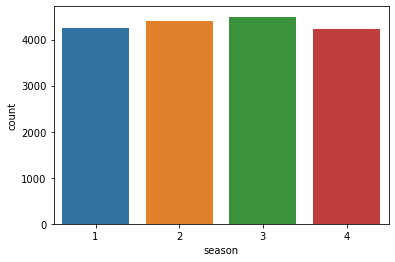

<IPython.core.display.Javascript object>

In [10]:
sns.countplot(x=df["season"])

## Праздник (holiday)

<AxesSubplot:xlabel='holiday', ylabel='count'>

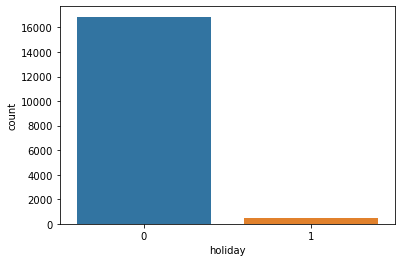

<IPython.core.display.Javascript object>

In [11]:
sns.countplot(x=df["holiday"])

## Рабочий день (workingday)

<AxesSubplot:xlabel='workingday', ylabel='count'>

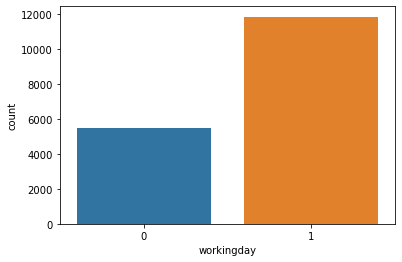

<IPython.core.display.Javascript object>

In [12]:
sns.countplot(x=df["workingday"])

## Погода (weather)

<AxesSubplot:xlabel='weather', ylabel='count'>

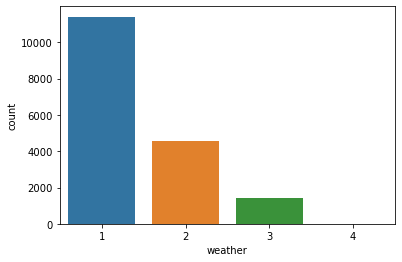

<IPython.core.display.Javascript object>

In [13]:
sns.countplot(x=df["weather"])

## Температура °C (temp)

<AxesSubplot:xlabel='temp', ylabel='Count'>

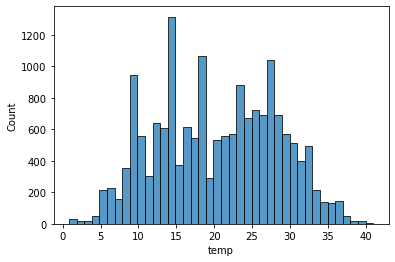

<IPython.core.display.Javascript object>

In [14]:
sns.histplot(x=df["temp"])

## Температура "по ощущениям" °C (atemp)

<AxesSubplot:xlabel='atemp', ylabel='Count'>

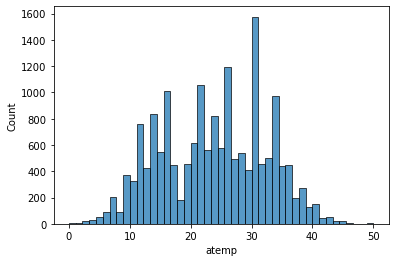

<IPython.core.display.Javascript object>

In [15]:
sns.histplot(x=df["atemp"])

## Относительная влажность (humidity)

<AxesSubplot:xlabel='humidity', ylabel='Count'>

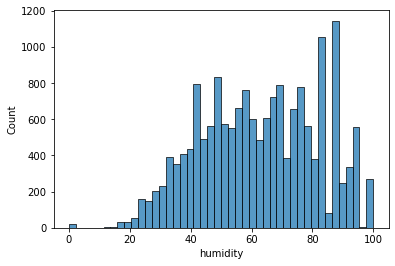

<IPython.core.display.Javascript object>

In [16]:
sns.histplot(x=df["humidity"])

## Скорость ветра (windspeed)

<AxesSubplot:xlabel='windspeed'>

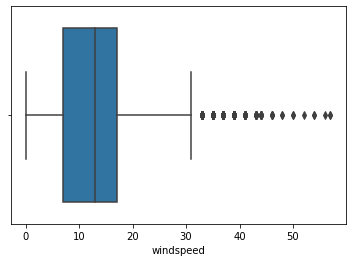

<IPython.core.display.Javascript object>

In [17]:
sns.boxplot(x=df["windspeed"])

# Подготовка выборок

In [18]:
y = df[["count"]]
X = df.drop(["count", "registered", "casual"], axis=1)
X.shape, y.shape

((17379, 8), (17379, 1))

<IPython.core.display.Javascript object>

# Генерация признаков

In [19]:
# выделение признаков из даты
X["year"] = X.index.year
X["month"] = X.index.month
X["day"] = X.index.day
X["hour"] = X.index.hour

X["dayofweek"] = X.index.dayofweek
X["is_weekand"] = X.index.weekday.isin([5, 6]) * 1

<IPython.core.display.Javascript object>

In [20]:
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/
# https://habr.com/ru/company/ods/blog/327242/


def make_ts_features(ts_df, max_lag=7, rolling_size=4, expanding_size=2):
    tmp_df = pd.DataFrame()
    for column_name in ts_df.columns:
        # лаги исходного ряда в качестве признаков
        for lag in range(1, max_lag + 1):
            tmp_df["{}_lag_{}".format(column_name, lag)] = ts_df[column_name].shift(lag)

        # скользяшее окно
        tmp_df["%s_rolling_mean" % column_name] = (
            ts_df[column_name].rolling(rolling_size).mean()
        )

        # скользящее окно с учетом прошлых значений (expanding window)
        tmp_df["%s_expanding_mean" % column_name] = (
            ts_df[column_name].expanding(expanding_size).mean()
        )

    return tmp_df.fillna(0)

<IPython.core.display.Javascript object>

In [21]:
# ts_df = df[["temp", "atemp", "humidity", "windspeed"]]
# ts_df = make_ts_features(ts_df)

# X = X.join(ts_df)
# X

<IPython.core.display.Javascript object>

# Построение модели и отбор признаков

In [22]:
X_test = X[X.index.isin(test.index)]

X = X[X.index.isin(train.index)]
y = y[y.index.isin(train.index)].astype(int)

X.shape, y.shape, X_test.shape

((10886, 14), (10886, 1), (6493, 14))

<IPython.core.display.Javascript object>

In [23]:
X, X_true, y, y_true = train_test_split(
    X, y, test_size=0.1, shuffle=False, random_state=42
)
X.shape, X_true.shape, y.shape, y_true.shape

((9797, 14), (1089, 14), (9797, 1), (1089, 1))

<IPython.core.display.Javascript object>

## Подбор гиперпараметров

In [24]:
model = CatBoostRegressor(logging_level="Silent")

# https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html
grid_params = {
    "depth": [3, 1, 2, 6, 4, 5, 7, 8, 9, 10],
    "iterations": [250, 100, 500, 1000],
    "learning_rate": [0.03, 0.001, 0.01, 0.1, 0.2, 0.3],
    "l2_leaf_reg": [3, 1, 5, 10, 100],
}

grid_search_result = model.grid_search(
    grid_params, Pool(X, y), cv=3, verbose=False, plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<IPython.core.display.Javascript object>

In [25]:
best_model_params = grid_search_result["params"]
best_model_params

{'depth': 8, 'l2_leaf_reg': 3, 'iterations': 1000, 'learning_rate': 0.03}

<IPython.core.display.Javascript object>

## Обучение

In [26]:
tscv = TimeSeriesSplit(n_splits=10)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)

<IPython.core.display.Javascript object>

In [27]:
def learn(X, y):
    ensemble = []

    for train_index, val_index in tscv.split(X):
        X_sub_train, X_sub_valid = X.iloc[train_index], X.iloc[val_index]
        y_sub_train, y_sub_valid = y.iloc[train_index], y.iloc[val_index]

        train_pool = Pool(X_sub_train, y_sub_train)
        valid_pool = Pool(X_sub_valid, y_sub_valid)

        model = CatBoostRegressor(**best_model_params)
        model.fit(train_pool, eval_set=valid_pool, verbose=False)

        ensemble.append(model)
        print(model.get_best_score())

    models_avrg = sum_models(ensemble, weights=[1.0 / len(ensemble)] * len(ensemble))
    return to_regressor(models_avrg)

<IPython.core.display.Javascript object>

In [28]:
models_avrg = learn(X, y)
models_avrg

{'learn': {'RMSE': 0.16617041915166283}, 'validation': {'RMSE': 0.6604652524349547}}
{'learn': {'RMSE': 0.21335892125049802}, 'validation': {'RMSE': 0.6530165642383422}}
{'learn': {'RMSE': 0.24882137623479375}, 'validation': {'RMSE': 0.4282685767865653}}
{'learn': {'RMSE': 0.26039273008512587}, 'validation': {'RMSE': 0.45500166754367144}}
{'learn': {'RMSE': 0.2762287865521595}, 'validation': {'RMSE': 0.44752336290838857}}
{'learn': {'RMSE': 0.28469038451460166}, 'validation': {'RMSE': 0.7860187213130513}}
{'learn': {'RMSE': 0.2986536329407921}, 'validation': {'RMSE': 0.5168467658769286}}
{'learn': {'RMSE': 0.30329522103569256}, 'validation': {'RMSE': 0.4512106083489559}}
{'learn': {'RMSE': 0.3051122751146226}, 'validation': {'RMSE': 0.3899801728811413}}
{'learn': {'RMSE': 0.3076194728967239}, 'validation': {'RMSE': 0.40030657214452103}}


<IPython.core.display.Javascript object>

# Сохранение результатов

In [29]:
y_true

,count
datetime,
2012-10-12 14:00:00,5
2012-10-12 15:00:00,6
2012-10-12 16:00:00,6
2012-10-12 17:00:00,6
2012-10-12 18:00:00,6
...,...
2012-12-19 19:00:00,5
2012-12-19 20:00:00,5
2012-12-19 21:00:00,5


<IPython.core.display.Javascript object>

In [30]:
y_pred = np.round(models_avrg.predict(X_true))
y_pred

array([5., 5., 5., ..., 4., 4., 4.])

<IPython.core.display.Javascript object>

In [31]:
mean_squared_error(y_true, y_pred, squared=False)

0.7132486239963527

<IPython.core.display.Javascript object>

In [32]:
models_avrg = learn(pd.concat([X, X_true]), pd.concat([y, y_true]))
models_avrg

{'learn': {'RMSE': 0.16927557188629}, 'validation': {'RMSE': 0.6773819904380974}}
{'learn': {'RMSE': 0.2257961074468555}, 'validation': {'RMSE': 0.5114096141824528}}
{'learn': {'RMSE': 0.25043582703840517}, 'validation': {'RMSE': 0.4388566571929135}}
{'learn': {'RMSE': 0.26914576901739534}, 'validation': {'RMSE': 0.4394157418274787}}
{'learn': {'RMSE': 0.28054411748459457}, 'validation': {'RMSE': 0.6786983291282925}}
{'learn': {'RMSE': 0.29670704744593535}, 'validation': {'RMSE': 0.4967335712878547}}
{'learn': {'RMSE': 0.30232221991455893}, 'validation': {'RMSE': 0.4282897737258974}}
{'learn': {'RMSE': 0.30452093926415646}, 'validation': {'RMSE': 0.3845623384259659}}
{'learn': {'RMSE': 0.3071084552132346}, 'validation': {'RMSE': 0.39791975177625644}}
{'learn': {'RMSE': 0.3099727460714808}, 'validation': {'RMSE': 0.4113413654850708}}


<IPython.core.display.Javascript object>

In [33]:
y_pred = models_avrg.predict(X_test)
y_pred = np.round(np.expm1(y_pred))

submission = pd.DataFrame({"datetime": X_test.index, "count": y_pred}).set_index(
    "datetime"
)
submission

,count
datetime,
2011-01-20 00:00:00,6.0
2011-01-20 01:00:00,3.0
2011-01-20 02:00:00,2.0
2011-01-20 03:00:00,1.0
2011-01-20 04:00:00,1.0
...,...
2012-12-31 19:00:00,101.0
2012-12-31 20:00:00,79.0
2012-12-31 21:00:00,63.0


<IPython.core.display.Javascript object>

In [34]:
submission.to_csv("../data/bike-sharing-demand/submission.csv")

<IPython.core.display.Javascript object>